<a href="https://colab.research.google.com/github/ummeasalma/Aladin-s-Travel/blob/master/temp/Car_Make_Model_Detection_VGG16_Ummea_imagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Car Model Detection:

### Team 6:

## Todo:
- [x] Import the DataSet.
- [x] Preprocessing
- [ ] Feature Selection
- [ ] Model Selection
- [ ] Training the Model

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPool2D
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/Dataset/DataSet.zip > /dev/null # output to null

In [ ]:
import numpy as np
import pandas as pd
metadata = pd.read_csv("DataSet/data/meta.csv")
metadata.head()

,Unnamed: 0,class_name
0,1,AM General Hummer SUV 2000
1,2,Acura RL Sedan 2012
2,3,Acura TL Sedan 2012
3,4,Acura TL Type-S 2008
4,5,Acura TSX Sedan 2012


Checking if image dataset is loaded

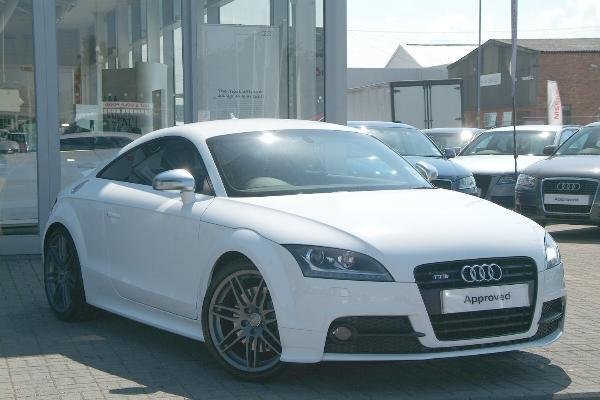

In [ ]:
import tensorflow as tf
img = tf.keras.preprocessing.image.load_img('DataSet/images/cars_train/00001.jpg')
img

In [ ]:
print(img.width, img.height)

600 400


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
print("Meta Data: \n")
print("Head:")
print(metadata.head())
print("\n Info:")
print(metadata.info())
print("\n Columns:")
print(metadata.columns)

Meta Data: 

Head:
   Unnamed: 0                  class_name
0           1  AM General Hummer SUV 2000
1           2         Acura RL Sedan 2012
2           3         Acura TL Sedan 2012
3           4        Acura TL Type-S 2008
4           5        Acura TSX Sedan 2012

 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  196 non-null    int64 
 1   class_name  196 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.2+ KB
None

 Columns:
Index(['Unnamed: 0', 'class_name'], dtype='object')


## Load the Train & Test Datasets

### Train Data

In [ ]:
train_data = pd.read_csv("DataSet/data/train.csv")

print("\n Train Data: \nHead: ")
train_data.head()
print("\nDescribe:")
print(train_data.describe())
print("\nInfo:")
print(train_data.info())
print("\nColumns:")
print(train_data.columns)
print("\nShape:")
print(train_data.shape)


 Train Data: 
Head: 

Describe:
         Unnamed: 0            x1            y1            x2            y2  \
count  12948.000000  12948.000000  12948.000000  12948.000000  12948.000000   
mean    3451.892339     64.701189    108.592833    638.598625    416.670683   
std     2200.262018     81.774972    106.195279    409.613163    272.818630   
min        0.000000      1.000000      1.000000     76.000000     41.000000   
25%     1618.000000     19.000000     42.000000    394.000000    250.000000   
50%     3236.500000     39.000000     80.000000    572.000000    361.000000   
75%     4906.250000     78.000000    138.000000    742.250000    475.000000   
max     8143.000000   1648.000000   1651.000000   5205.000000   3389.000000   

              class  
count  12948.000000  
mean      99.008573  
std       56.540538  
min        1.000000  
25%       50.000000  
50%       99.000000  
75%      148.000000  
max      196.000000  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 

### Test Data

In [ ]:
test_data = pd.read_csv("DataSet/data/test.csv") #load test data


print("\n Train Data: \nHead: ")
test_data.head()
print("\nDescribe:")
print(test_data.describe())
print("\nInfo:")
print(test_data.info())
print("\nColumns:")
print(test_data.columns)
print("\nShape:")
print(test_data.shape)


 Train Data: 
Head: 

Describe:
        Unnamed: 0           x1           y1           x2           y2  \
count  3237.000000  3237.000000  3237.000000  3237.000000  3237.000000   
mean   1618.000000    66.103491   106.835650   639.691999   417.637010   
std     934.585737    84.198376   106.736782   417.499266   279.758425   
min       0.000000     1.000000     1.000000    72.000000    49.000000   
25%     809.000000    18.000000    40.000000   389.000000   242.000000   
50%    1618.000000    39.000000    77.000000   573.000000   363.000000   
75%    2427.000000    80.000000   135.000000   763.000000   487.000000   
max    3236.000000   872.000000  1311.000000  7224.000000  3835.000000   

             class  
count  3237.000000  
mean     98.852950  
std      56.359186  
min       1.000000  
25%      51.000000  
50%      99.000000  
75%     148.000000  
max     196.000000  

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3237 entries, 0 to 3236
Data columns (total 7 columns)

**Let's get an Average of images available per class**

We should get around 66 images per class with the `stanford car dataset`

In [ ]:
counter = 0 #no. of images available per class in our dataset
average = 0 #average no. of images availabe for all our classes for training

for y in range(1, 197):
  for x in train_data['class']:
    if (x == y):
      # print("x, y", x, y)
      counter = counter+1;
  average = (average + counter)/y


print("Average:", average)

Average: 66.4000624886608


### Image Resising and Fixing the `fname` for one of the value in CSV

In [ ]:
from PIL import Image
import os

In [ ]:
# fix the file names here
train_data.loc[9998, 'fname'] = '09999.jpg'

resizing the images to 128x128 resolution

In [ ]:
new_size = (128,128)

Creating a variable for resized data that we can use to update the bounding box information

In [ ]:
train_data_resized = train_data.copy()
train_data_resized.shape

(12948, 7)

## ***Before I resize the images, I wanna see the small resolution image available in the dataset to avoid any mis handling of images during the training phase of dataset***

In [ ]:
temp_width = 190000 # some random value which should be high to compare and get the smallest width(px size) of the available images in the dataset
temp_height = 19000

smallest_width_image = ""
smallest_height_image = ""


def ImageSizeChecker():
  global temp_width, temp_height, smallest_height_image, smallest_width_image
  # print(train_data['fname'][0])
  for i in range(1, 12948):
    image_path = 'DataSet/images/cars_train/' + train_data['fname'][i]
    img = tf.keras.preprocessing.image.load_img(image_path)
    # print(img.width, img.height)
    if (img.width < temp_width):
      temp_width = img.width
      smallest_width_image = train_data['fname'][i]
      # print("Image Width Size for ", i, "th image: ",  temp_width)
    if (img.height < temp_height):
      temp_height = img.width
      smallest_height_image = train_data['fname'][i]
      # print("Image height Size for ", i, "th image: ",  temp_width)
    if i == 12947:
      print("END")
      print(temp_width, temp_height)
      print(smallest_width_image, smallest_height_image)


ImageSizeChecker()



END
78 96
00097.jpg 12942.jpg


Checking which images have low resolution

train_data name 00097.jpg
train_data name 12942.jpg


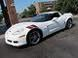

In [ ]:
small_image_1 = 'DataSet/images/cars_train/' + train_data['fname'][96]
print("train_data name", train_data['fname'][96])
img1 = tf.keras.preprocessing.image.load_img(small_image_1)


small_image_2 = 'DataSet/images/cars_train/' + train_data['fname'][12941]
print("train_data name", train_data['fname'][12941])
img2 = tf.keras.preprocessing.image.load_img(small_image_2)
img1

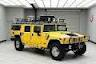

In [ ]:
img2

### Crop and Resize the Training DataSet images to 224x224 pixels:

> Cropping the images using bounding boxes and separating the images into their respective folders accoringly.

*   Read the dataset from CSV file
*   Iterate over each image, resize it and its bounding box in CSV
*   Crop the image using bounding box coordinates
*   Resize the croppedImage to 224x224 pixels (CNNs can easily train on square images)
*   Save the cropped resize image
*   ~~Update the bounding box coordinates in the new dataframe called `train_data_resized`.~~

> Resizing the dataset to a square size  helps in training the model much faster as we deal with image datasets which inturn uses matrix multiplications for this type of problem




 **Resizing the images to 224x224 resolution**

> ***Choosing 224x224 as an ideal choice since it may contain more details of each car for classification***

In [ ]:
new_size = (224,224)

In [ ]:
# Image Cropper Function
def ImageCropper(save_path, class_name, image_path, x1, y1, x2, y2):
  im = Image.open(image_path);
  croppedImage = im.crop((x1, y1, x2, y2))

  # print("Cropping Finished")
  filename = os.path.basename(image_path)
  # class_image_save_path = save_path + "/" + str(class_name) + "/" # this line separates all the images to separate folders according to the class no.
  class_image_save_path = save_path + "/"


  resized_image = croppedImage.resize(new_size)

  #save the resized image
  if not os.path.exists(class_image_save_path):
    os.makedirs(class_image_save_path)

  resized_image.save(os.path.join(class_image_save_path, filename))



In [ ]:
!rm -r DataSet/croppedResizedImages/

rm: cannot remove 'DataSet/croppedResizedImages/': No such file or directory


In [ ]:
# dataset folder for training data
dataset_image_folder = 'DataSet/images/cars_train/'

cropped_images_save_path ='DataSet/croppedResizedImages' #setting a custom path for storing the resized data

In [ ]:
# dataset folder for testing data
dataset_image_folder_test = 'DataSet/images/cars_test/'

cropped_test_images_save_path ='DataSet/croppedResizedImagesTest' #setting a custom path for storing the resized data

In [ ]:
print(len(train_data))

12948


In [ ]:
print(len(test_data))

3237


In [ ]:
# process each image - cropping (Training)
for index, row in train_data.iterrows():

  # Call the image cropper function
  ImageCropper(cropped_images_save_path, train_data['class'][index] , dataset_image_folder + train_data['fname'][index], train_data['x1'][index], train_data['y1'][index], train_data['x2'][index], train_data['y2'][index])

  if index == len(train_data) - 1:
    print("All Images have been cropped")


All Images have been cropped


In [ ]:
# process each image - cropping (Testing)
for index, row in test_data.iterrows():

  # Call the image cropper function
  ImageCropper(cropped_test_images_save_path, test_data['class'][index] , dataset_image_folder_test + test_data['fname'][index], test_data['x1'][index], test_data['y1'][index], test_data['x2'][index], test_data['y2'][index])

  if index == len(test_data) - 1:
    print("All Images of test data have been cropped")

All Images of test data have been cropped


Creating a variable for resized data that we can use to update the bounding box information

In [ ]:
train_data_resized = train_data.copy()
train_data_resized.shape

(12948, 7)

In [ ]:
test_data_resized = test_data.copy()
test_data_resized.shape

(3237, 7)

In [ ]:
# !ls DataSet/images/cars_train #uncomment to see the show the no. of images we have

In [ ]:
# !ls DataSet/resized_images/ #let's see the count of resized cropped images.

In [ ]:
train_data_resized = train_data_resized.drop(columns=["x1", "y1", "x2", "y2"])
test_data_resized = test_data_resized.drop(columns=["x1", "y1", "x2", "y2"])

In [ ]:
train_data_resized.head()

,Unnamed: 0,class,fname
0,0,14,00001.jpg
1,1,3,00002.jpg
2,2,91,00003.jpg
3,3,134,00004.jpg
4,4,106,00005.jpg


In [ ]:
test_data_resized.head()

,Unnamed: 0,class,fname
0,0,181,00001.jpg
1,1,103,00002.jpg
2,2,145,00003.jpg
3,3,187,00004.jpg
4,4,185,00005.jpg


## Check the resized image.

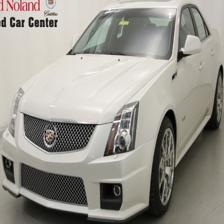

In [ ]:
scaled_img = tf.keras.preprocessing.image.load_img('DataSet/croppedResizedImages/00098.jpg')
scaled_img

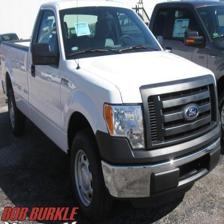

In [ ]:
scaled_img = tf.keras.preprocessing.image.load_img('DataSet/croppedResizedImagesTest/00098.jpg')
scaled_img

Split data into Training and validation set

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
X_train = train_data_resized.drop(columns=["class"])  # Features
y_train = train_data_resized["class"]  # Target variable which in our case is class

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42) #training set 80% validation set 20%

In [ ]:
X_train.shape

(10358, 2)

In [ ]:
X_val.shape

(2590, 2)

In [ ]:
y_train.shape

(10358,)

In [ ]:
y_val.shape

(2590,)

In [ ]:
X_train.head()

,Unnamed: 0,fname
6821,6821,06822.jpg
2498,2498,02499.jpg
1851,1851,01852.jpg
8128,8128,08129.jpg
4533,4533,04534.jpg


In [ ]:
X_test = test_data_resized.drop(columns=["class"])  # Features
y_test = test_data_resized["class"]  # Target variable which in our case is class

#Prepare the Data for Machine Learning Algorithms

Checking we have any missing value

In [ ]:
sample_incomplete_rows = train_data_resized[train_data_resized.isnull().any(axis=1)].head() #maybe we don't have any missing data
pd.set_option('display.max_columns', None)
sample_incomplete_rows

,Unnamed: 0,class,fname


> WE DON'T HAVE TO DO NORMALIZATION AS WE DID IT WHEN WE RESIZED THE IMAGES TO SAME RESOLUTION


### This step helps in training the transfer learning model much easier.

# Load all the Images to start traning


In [ ]:
import cv2  # Or from PIL import Image  if using Pillow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Define data paths

In [ ]:
image_train_data_dir = "DataSet/croppedResizedImages/"
# test_data_dir = "" # let's redefine it later

In [ ]:
def load_image(filepath, target_size=(224, 224)):  # Adjust target size if needed
    img = cv2.imread(filepath)  # Or img = Image.open(filepath) for Pillow
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB if using OpenCV
    img = cv2.resize(img, target_size)
    return img

### Prepare Training Data

Creating a dictionary to map image filenames to their corresponding class labels

In [ ]:
image_label_map = dict(zip(train_data_resized["fname"], train_data_resized["class"]))  # Adjust column names if needed

###  Data Augmentation (Highly Recommended):

Create an ImageDataGenerator object to perform on-the-fly data augmentation during training, which helps prevent overfitting and improve model generalization perform Data Augmentation

> **In Simple, we generate different transformations of images to increase the image dataset size and balance it for our training since we are extremely dealing with very small dataset.**

Since the dataset is limited, augmenting our data artificially increasing the diversity of our training data.

In [ ]:
# Convert "class" column to string before using flow_from_dataframe
train_data_resized['class'] = train_data_resized['class'].astype(str)

In [ ]:
test_data_resized['class'] = test_data_resized['class'].astype(str)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,           # Horizontal shifts, simulating different angles
    height_shift_range=0.2,          # Vertical shifts, cars at different distances
    shear_range=0.15,                 # Shear, simulating camera angle changes
    zoom_range=0.15,                  # Zoom, simulating cars moving closer or further away
)

In [ ]:
test_datagen = ImageDataGenerator()

### Load and Augment Training Data:

Use train_datagen.flow_from_directory to automatically load, preprocess, and augment images from your training directory:

Use train_datagen.flow_from_dataframe to generate batches of images and labels from your DataFrame:

In [ ]:
X_train

,Unnamed: 0,fname
6821,6821,06822.jpg
2498,2498,02499.jpg
1851,1851,01852.jpg
8128,8128,08129.jpg
4533,4533,04534.jpg
...,...,...
11964,3820,11965.jpg
5191,5191,05192.jpg
5390,5390,05391.jpg
860,860,00861.jpg


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_resized,
    directory=image_train_data_dir,  # Point to the image directory
    x_col="fname",  # Column containing image filenames (adjust if needed)
    y_col="class",  # Column containing class labels (adjust if needed)
    target_size=(224, 224),  # Adjust target size if needed
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    shuffle=True,  # Shuffle data for better training
    seed=42,  # For reproducibility of data shuffling and augmentations.
    # validation_split=0.2,
    subset='training',  # Specify this is for validation data
)


Found 12948 validated image filenames belonging to 196 classes.


In [ ]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_data_resized,
    directory=image_train_data_dir,  # Point to the image directory
    x_col="fname",  # Column containing image filenames (adjust if needed)
    y_col="class",  # Column containing class labels (adjust if needed)
    target_size=(224, 224),  # Adjust target size if needed
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    shuffle=False,  # Shuffle data for better training
    seed=42,  # For reproducibility of data shuffling and augmentations.
    # validation_split=0.2,
    subset='training',  # Specify this is for validation data
)

Found 3237 validated image filenames belonging to 196 classes.


In [ ]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data_resized,
    directory=image_train_data_dir,  # Point to the image directory
    x_col="fname",  # Column containing image filenames (adjust if needed)
    y_col="class",  # Column containing class labels (adjust if needed)
    target_size=(224, 224),  # Adjust target size if needed
    batch_size=32,  # Adjust batch size as needed
    class_mode='categorical',  # Multi-class classification
    shuffle=True,  # Shuffle data for better training
    seed=42,  # For reproducibility of data shuffling and augmentations.
    # validation_split=0.2,
    subset='validation',  # Specify this is for validation data
)


Found 0 validated image filenames belonging to 196 classes.


#Defining the VGG16 model as a sequential mode

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

def VGG16():
    model = Sequential()

    # Block 1
    model.add(Conv2D(input_shape=(224,224,3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    # Block 2
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    # Block 3
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    # Block 4
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

    # Block 5
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), name='vgg16'))

    # Fully connected layers
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='fc1'))
    model.add(Dense(128, activation='relu', name='fc2'))
    model.add(Dense(196, activation='softmax', name='output'))

    return model

# Create VGG16 model
model = VGG16()

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 128)       0         
 g2D)                                                   

In [ ]:
# Define Vgg16 model to extract features
Vgg16 = Model(inputs=model.input, outputs=model.get_layer('vgg16').output)

# Load pre-trained weights
Vgg16.load_weights("/content/gdrive/MyDrive/Dataset/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5")

# Set early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

# Compile the model
opt = SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# Freeze layers for transfer learning
for layer in Vgg16.layers:
    layer.trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e054b9d0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e0d9dbd0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c46e4f178e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e0494e50> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e0494d90> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c46e4f163b0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e04965c0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e0496890> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e0497c70> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7c46e0497a90> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e02d8b20> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7c46e02d9d20> False
<keras.src.layers.convolutional.conv2d.Conv

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the model checkpoint
mc = ModelCheckpoint('/DataSet/vgg16_best_model_1.h5', monitor='val_accuracy', mode='max', save_best_only=True)

# Fit the model
H = model.fit_generator(train_generator, validation_data=test_generator, epochs=150, verbose=1, callbacks=[mc, es])

<ipython-input-62-9f825d2a851d>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator, validation_data=test_generator, epochs=150, verbose=1, callbacks=[mc, es])


Epoch 1/150
 25/405 [>.............................] - ETA: 6:20:37 - loss: 20.0339 - accuracy: 0.0012

# PENDING FROM HERE

## Imporing ResNet50 to the Transfer learning as the training data for each class is minimal in our dataset

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [ ]:
model = Sequential([ResNet50(include_top=False, weights='imagenet', pooling='avg'), Dense(196, activation='softmax')])

In [ ]:
model.layers[0].trainable = False # Freeze the layers except for last one

In [ ]:
model

In [ ]:
# Compile the model for training with your specific optimizer and loss function
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model on your car image dataset (data preparation not shown here)
# model.fit(train_generator, your_training_labels, epochs=10)

In [ ]:
# Use the trained model for car make/model prediction on new images
# predictions = model.predict(your_new_image)

In [ ]:
len(train_generator)

1295

In [ ]:
# Train the model on the training data
# model.fit(
#     train_generator,
#     validation_generator,
#     epochs=10,  # Adjust the number of epochs as needed
#     # steps_per_epoch=len(train_generator)  # Adjust if using validation split
# )

model.fit(
    train_generator,
    epochs=50,  # Adjust according to your needs
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)


Epoch 1/50
1295/1295 [==============================] - 212s 163ms/step - loss: 5.5076 - accuracy: 0.0078 - val_loss: 5.4195 - val_accuracy: 0.0116
Epoch 2/50
1295/1295 [==============================] - 208s 161ms/step - loss: 5.4159 - accuracy: 0.0092 - val_loss: 5.4095 - val_accuracy: 0.0127
Epoch 3/50
1295/1295 [==============================] - 210s 162ms/step - loss: 5.3655 - accuracy: 0.0120 - val_loss: 5.3772 - val_accuracy: 0.0112
Epoch 4/50
1295/1295 [==============================] - 208s 161ms/step - loss: 5.3128 - accuracy: 0.0151 - val_loss: 5.3396 - val_accuracy: 0.0139
Epoch 5/50
1295/1295 [==============================] - 207s 160ms/step - loss: 5.2832 - accuracy: 0.0153 - val_loss: 5.2982 - val_accuracy: 0.0100
Epoch 6/50
1295/1295 [==============================] - 207s 160ms/step - loss: 5.2468 - accuracy: 0.0188 - val_loss: 5.2794 - val_accuracy: 0.0143
Epoch 7/50
1295/1295 [==============================] - 207s 160ms/step - loss: 5.2155 - accuracy: 0.0195 - val_

> **NOTE:** It is best to have validation set for evaluating the performance